# OSMnx Pipeline Test Notebook
Testing the multimodal accessibility analysis pipeline for Alameda County

## Pipeline Components
1. Load study area (county boundary)
2. Build walk network from OSM
3. Fetch amenities from OSM
4. Calculate distances to amenities
5. Analyze results

## Setup and Imports

In [3]:
import sys
import warnings
import time
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx

# Add src to path
sys.path.append("../src")

# Import pipeline modules
from osmnx_pipeline import config
from osmnx_pipeline.network import load_study_area, build_walk_network
from osmnx_pipeline.amenities import fetch_amenities
from osmnx_pipeline.distances import distance_to_amenity

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("✓ Imports successful")
print(f"OSMnx version: {ox.__version__}")
print(f"NetworkX version: {nx.__version__}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
✓ Imports successful
OSMnx version: 2.0.6
NetworkX version: 3.5


## Test 1: Load Gold Geometries
Verify that all gold layer geometries are accessible

In [4]:
print("Loading gold layer geometries...\n")

# Load address points
addr_path = config.ADDR_PATH
addresses = gpd.read_parquet(addr_path)
print(f"✓ Address Points: {len(addresses):,} features")
print(f"  CRS: {addresses.crs}")
print(f"  Bounds: {addresses.total_bounds}")

# Load county boundary
county_path = config.COUNTY_BOUNDARY_PATH
county = gpd.read_parquet(county_path)
print(f"\n✓ County Boundary: {len(county)} feature(s)")
print(f"  County: {county['county_name'].iloc[0]}")
print(f"  Area: {county['area_sqm'].iloc[0] / 1e6:.2f} km²")
print(f"  CRS: {county.crs}")

# Load census tracts
tracts_path = config.TRACTS_PATH
tracts = gpd.read_parquet(tracts_path)
print(f"\n✓ Census Tracts: {len(tracts):,} features")
print(f"  CRS: {tracts.crs}")

# Sample address data
print("\n" + "="*60)
print("Sample Address Data:")
print("="*60)
sample_cols = ['full_address', 'city', 'zipcode', 'x_coordinate', 'y_coordinate']
print(addresses[sample_cols].head())

Loading gold layer geometries...

✓ Address Points: 634,217 features
  CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbrevia

## Test 2: Load Study Area
Test the `load_study_area()` function

Testing load_study_area()...

✓ Study area loaded
  Type: Polygon
  Geometry type: Polygon
  CRS: EPSG:4326
  Bounds (lon, lat): (-122.373841572793, 37.4541928664208, -121.469338790912, 37.9066945547742)


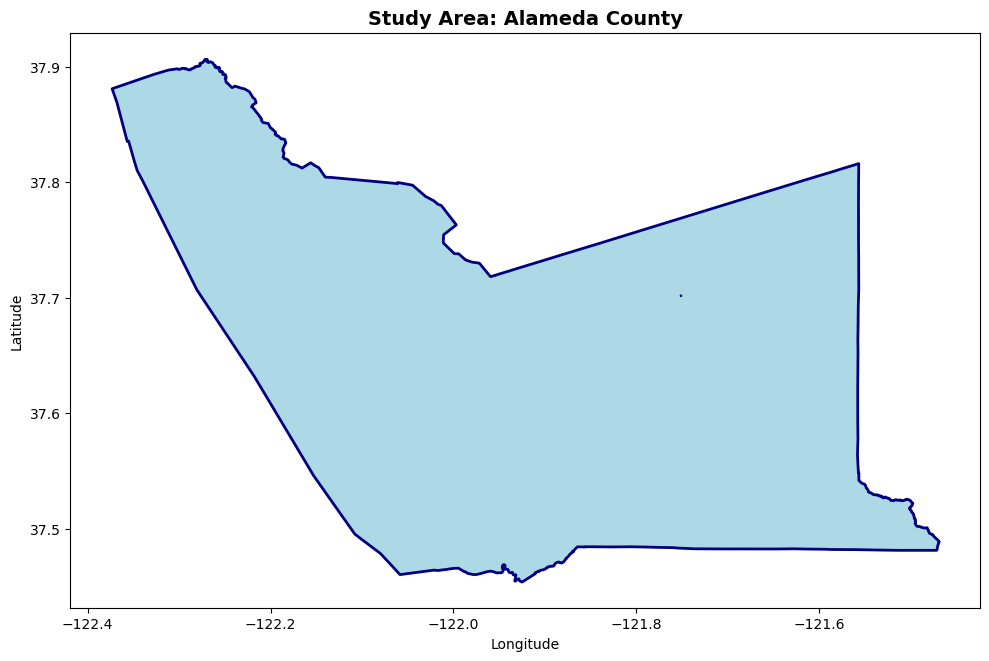


✓ Study area visualization complete


In [5]:
print("Testing load_study_area()...\n")

study_area = load_study_area()

print(f"✓ Study area loaded")
print(f"  Type: {type(study_area).__name__}")
print(f"  Geometry type: {study_area.geom_type}")
print(f"  CRS: {config.CRS_LATLON}")
print(f"  Bounds (lon, lat): {study_area.bounds}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
county_ll = county.to_crs(config.CRS_LATLON)
county_ll.plot(ax=ax, color='lightblue', edgecolor='navy', linewidth=2)
ax.set_title(f"Study Area: {county['county_name'].iloc[0]}", fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

print("\n✓ Study area visualization complete")

## Test 3: Build Walk Network
Download and build the pedestrian network from OSM

**Note:** This may take 5-15 minutes depending on network size

In [6]:
print("Building walk network from OSM...\n")
print("⏳ This may take 5-15 minutes for the full county...\n")

start_time = time.time()

try:
    G = build_walk_network()
    elapsed = time.time() - start_time
    
    print(f"\n✓ Network built in {elapsed/60:.1f} minutes\n")
    
    # Network statistics
    print("="*60)
    print("Network Statistics:")
    print("="*60)
    print(f"Nodes: {G.number_of_nodes():,}")
    print(f"Edges: {G.number_of_edges():,}")
    print(f"CRS: {G.graph['crs']}")
    print(f"Network type: walk")
    print(f"Is directed: {G.is_directed()}")
    print(f"Is connected: {nx.is_weakly_connected(G) if G.is_directed() else nx.is_connected(G)}")
    
    # Edge attributes
    sample_edge = list(G.edges(data=True))[0]
    print(f"\nEdge attributes: {list(sample_edge[2].keys())}")
    
    # Check for length attribute
    if 'length' in sample_edge[2]:
        lengths = [data['length'] for u, v, data in G.edges(data=True)]
        print(f"\nEdge lengths:")
        print(f"  Mean: {np.mean(lengths):.1f} meters")
        print(f"  Median: {np.median(lengths):.1f} meters")
        print(f"  Total: {np.sum(lengths)/1000:.1f} km")
    
    print("\n✓ Network test complete")
    
except Exception as e:
    print(f"❌ Error building network: {e}")
    print("\nTip: Try reducing the study area or checking your internet connection")
    raise

Building walk network from OSM...

⏳ This may take 5-15 minutes for the full county...


✓ Network built in 2.5 minutes

Network Statistics:
Nodes: 161,348
Edges: 445,984
CRS: EPSG:26910
Network type: walk
Is directed: True
Is connected: True

Edge attributes: ['osmid', 'highway', 'oneway', 'reversed', 'length']

Edge lengths:
  Mean: 67.0 meters
  Median: 35.7 meters
  Total: 29889.4 km

✓ Network test complete


## Test 4: Visualize Network Sample
Plot a small section of the network to verify it looks correct

Visualizing network sample...

Sample subgraph (500m radius):
  Nodes: 121
  Edges: 288


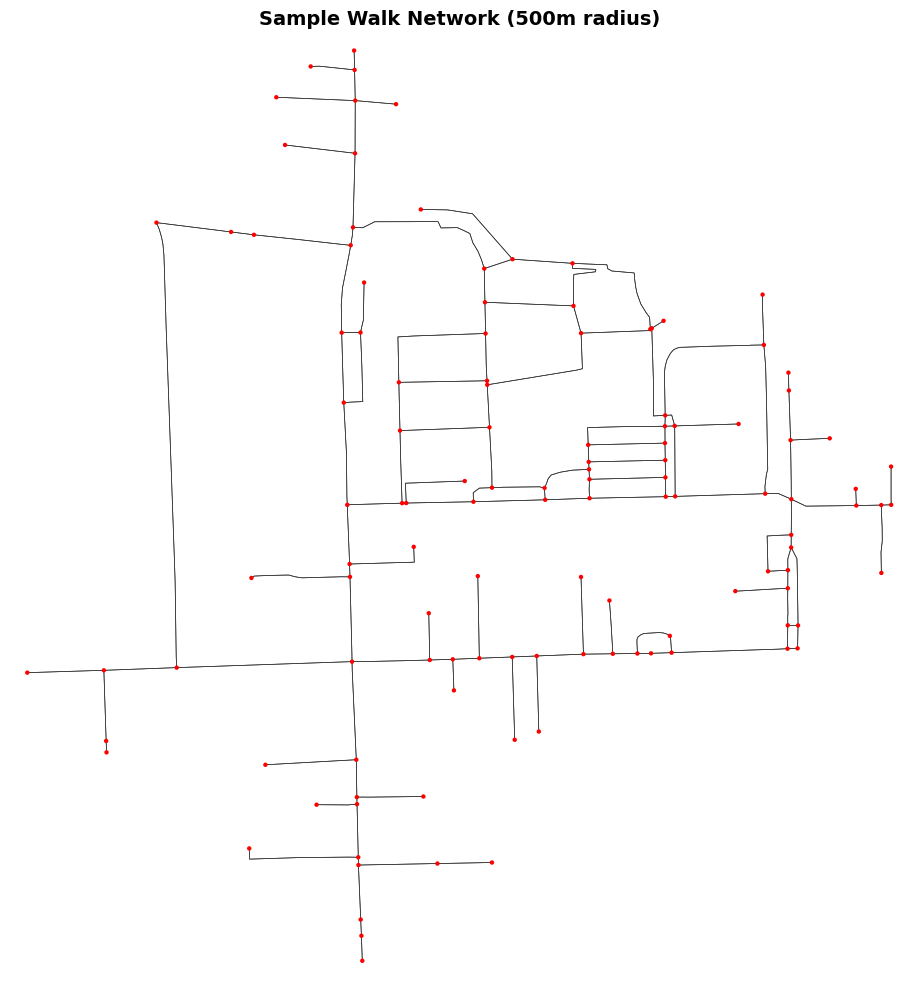


✓ Network visualization complete


In [7]:
print("Visualizing network sample...\n")

# Get a random sample of nodes (center of network)
all_nodes = list(G.nodes())
center_idx = len(all_nodes) // 2
center_node = all_nodes[center_idx]

# Get subgraph within 500m of center node
try:
    # Use single_source_dijkstra_path_length for weighted shortest paths
    subgraph_nodes = nx.single_source_dijkstra_path_length(G, center_node, cutoff=500, weight='length')
    H = G.subgraph(subgraph_nodes.keys())
    
    print(f"Sample subgraph (500m radius):")
    print(f"  Nodes: {H.number_of_nodes():,}")
    print(f"  Edges: {H.number_of_edges():,}")
    
    # Plot
    fig, ax = ox.plot_graph(H, node_size=10, node_color='red', 
                            edge_linewidth=0.5, edge_color='#333333',
                            bgcolor='white', figsize=(10, 10),
                            show=False, close=False)
    ax.set_title('Sample Walk Network (500m radius)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Network visualization complete")
    
except Exception as e:
    print(f"⚠️  Could not visualize subgraph: {e}")
    print("Network is still valid, visualization just failed")

## Test 5: Fetch Amenities
Test fetching each amenity type from OSM

In [8]:
print("Fetching amenities from OSM...\n")
print("Amenity types to fetch:")
for key in config.OSM_TAGS_HIGH.keys():
    print(f"  - {key}")
print()

amenities_dict = {}

for amenity_key in config.OSM_TAGS_HIGH.keys():
    print(f"Fetching {amenity_key}...", end=" ")
    try:
        start_time = time.time()
        amenities = fetch_amenities(amenity_key)
        elapsed = time.time() - start_time
        
        amenities_dict[amenity_key] = amenities
        print(f"✓ Found {len(amenities):,} locations ({elapsed:.1f}s)")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        amenities_dict[amenity_key] = None

print("\n" + "="*60)
print("Amenity Summary:")
print("="*60)
for key, gdf in amenities_dict.items():
    if gdf is not None:
        print(f"{key:20s}: {len(gdf):6,} locations")
    else:
        print(f"{key:20s}: Failed to fetch")

print("\n✓ Amenity fetch complete")

Fetching amenities from OSM...

Amenity types to fetch:
  - bus_stops
  - schools
  - parks
  - grocery_stores
  - pharmacies

Fetching bus_stops... ✓ Found 4,888 locations (53.6s)
Fetching schools... ✓ Found 182 locations (8.5s)
Fetching parks... ✓ Found 46 locations (9.7s)
Fetching grocery_stores... ✓ Found 117 locations (5.4s)
Fetching pharmacies... ✓ Found 57 locations (3.1s)

Amenity Summary:
bus_stops           :  4,888 locations
schools             :    182 locations
parks               :     46 locations
grocery_stores      :    117 locations
pharmacies          :     57 locations

✓ Amenity fetch complete


## Test 6: Visualize Amenities
Plot amenities on a map

Visualizing amenities...



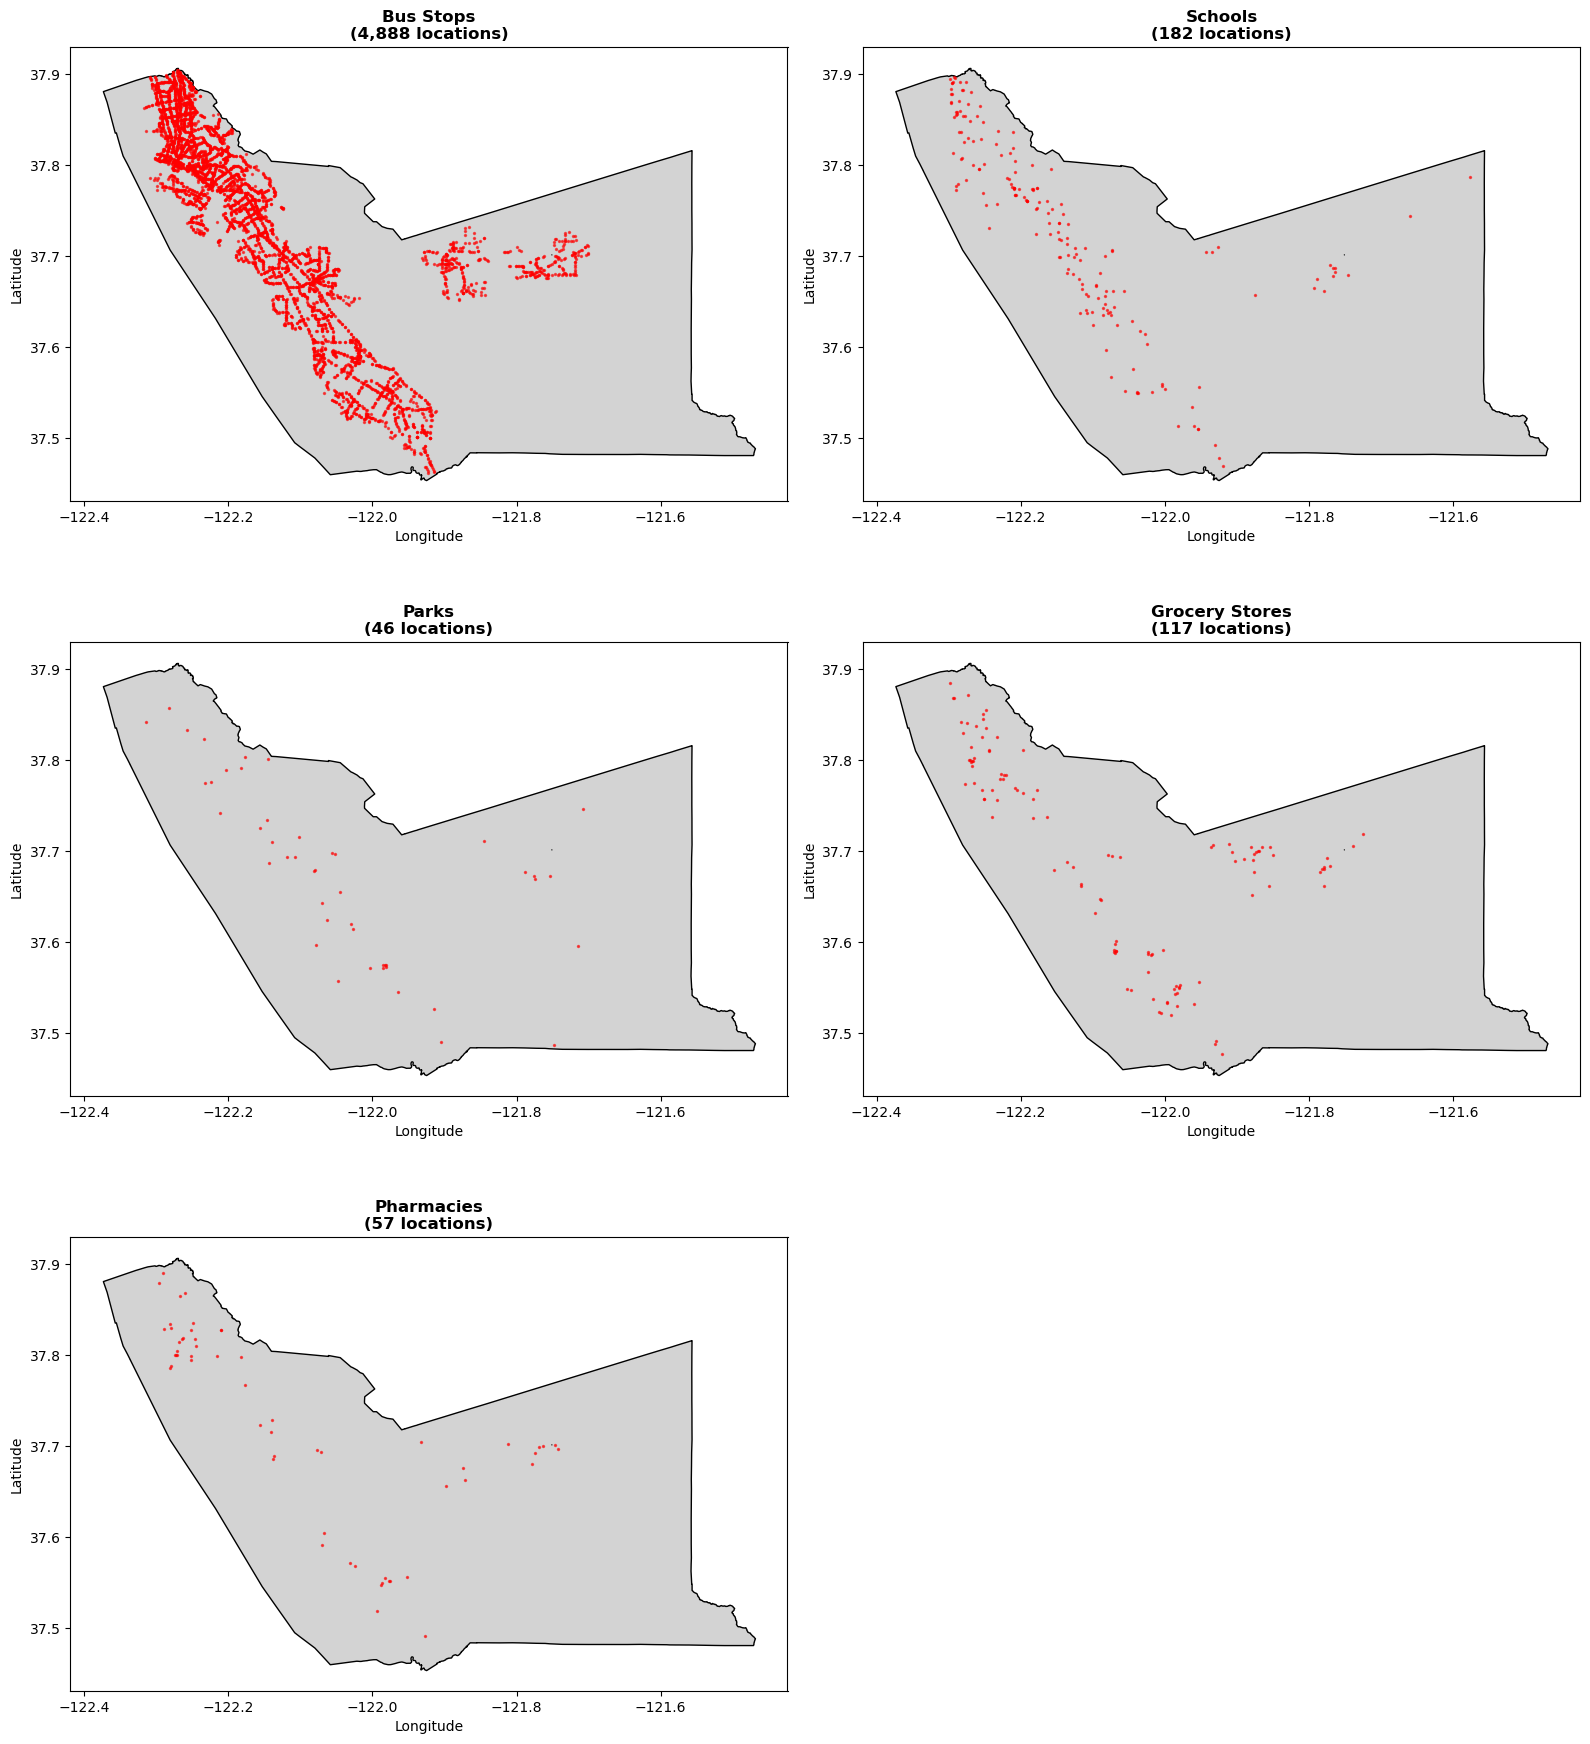

✓ Amenity visualization complete


In [ ]:
print("Visualizing amenities...\n")

# Create figure with subplots
n_amenities = len([a for a in amenities_dict.values() if a is not None])
n_cols = 2
n_rows = (n_amenities + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
axes = axes.flatten() if n_amenities > 1 else [axes]

county_ll = county.to_crs(config.CRS_LATLON)

for idx, (amenity_key, amenities) in enumerate(amenities_dict.items()):
    if amenities is not None and len(amenities) > 0:
        ax = axes[idx]
        
        # Plot county boundary
        county_ll.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)
        
        # Plot amenities
        amenities_ll = amenities.to_crs(config.CRS_LATLON)
        amenities_ll.plot(ax=ax, color='red', markersize=2, alpha=0.6)
        
        ax.set_title(f"{amenity_key.replace('_', ' ').title()}\n({len(amenities):,} locations)", 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Remove empty subplots
for idx in range(n_amenities, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("✓ Amenity visualization complete")


# I need this to also put the jurisdiction boundary on the plots

## Test 7: Calculate Distance to Bus Stops
Test the full distance calculation pipeline for one amenity type

In [10]:
print("Testing distance calculation for bus stops...\n")
print("⏳ This may take several minutes (snapping 634K addresses to network)...\n")

start_time = time.time()

try:
    addr_with_bus = distance_to_amenity("bus_stops")
    elapsed = time.time() - start_time
    
    print(f"\n✓ Distance calculation complete in {elapsed/60:.1f} minutes\n")
    
    # Check results
    print("="*60)
    print("Distance Calculation Results:")
    print("="*60)
    print(f"Total addresses: {len(addr_with_bus):,}")
    print(f"\nColumns: {list(addr_with_bus.columns)}")
    
    # Distance statistics
    dist_col = 'dist_bus_stops_m'
    distances = addr_with_bus[dist_col].dropna()
    
    print(f"\n{dist_col} statistics:")
    print(f"  Count: {len(distances):,}")
    print(f"  Missing: {len(addr_with_bus) - len(distances):,}")
    print(f"  Mean: {distances.mean():.1f} meters ({distances.mean()/1000:.2f} km)")
    print(f"  Median: {distances.median():.1f} meters ({distances.median()/1000:.2f} km)")
    print(f"  Std: {distances.std():.1f} meters")
    print(f"  Min: {distances.min():.1f} meters")
    print(f"  Max: {distances.max():.1f} meters ({distances.max()/1000:.1f} km)")
    
    # Percentiles
    print(f"\nPercentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        val = distances.quantile(p/100)
        print(f"  {p:2d}th: {val:7.1f} meters ({val/1000:.2f} km)")
    
    print("\n✓ Bus stop distance test complete")
    
except Exception as e:
    print(f"❌ Error calculating distances: {e}")
    raise

Testing distance calculation for bus stops...

⏳ This may take several minutes (snapping 634K addresses to network)...


✓ Distance calculation complete in 2.8 minutes

Distance Calculation Results:
Total addresses: 634,217

Columns: ['OBJECTID', 'parcel_number', 'street_number', 'street_name', 'street_type', 'direction_prefix', 'direction_suffix', 'municipality', 'unit_number', 'unit_type', 'source_date', 'revision_date', 'address_point_id', 'full_address', 'city', 'zipcode', 'address_lookup', 'x_coordinate', 'y_coordinate', 'geometry', 'nearest_node', 'dist_bus_stops_m']

dist_bus_stops_m statistics:
  Count: 634,217
  Missing: 0
  Mean: 467.4 meters (0.47 km)
  Median: 281.0 meters (0.28 km)
  Std: 760.0 meters
  Min: 0.0 meters
  Max: 36308.1 meters (36.3 km)

Percentiles:
  10th:    69.5 meters (0.07 km)
  25th:   145.0 meters (0.15 km)
  50th:   281.0 meters (0.28 km)
  75th:   512.6 meters (0.51 km)
  90th:   951.4 meters (0.95 km)
  95th:  1466.7 meters (1.47 km)
  99th:  3266.

## Test 8: Visualize Distance Distribution
Create histogram and summary plots

Visualizing distance distributions...



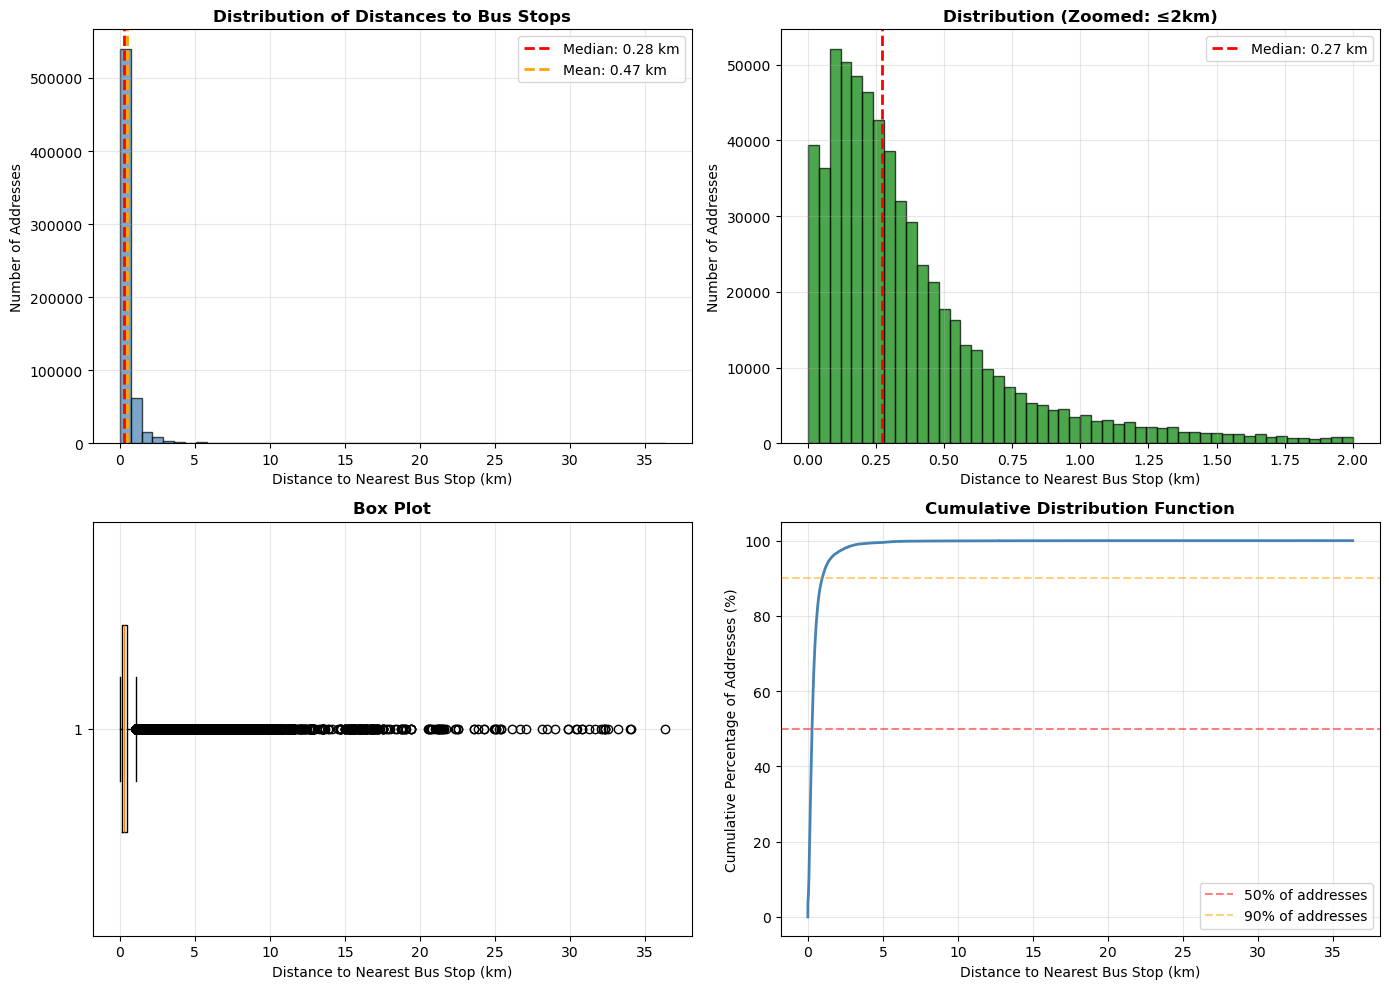

✓ Distance visualization complete


In [11]:
print("Visualizing distance distributions...\n")

dist_col = 'dist_bus_stops_m'
distances = addr_with_bus[dist_col].dropna() / 1000  # Convert to km

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax = axes[0, 0]
ax.hist(distances, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(distances.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {distances.median():.2f} km')
ax.axvline(distances.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {distances.mean():.2f} km')
ax.set_xlabel('Distance to Nearest Bus Stop (km)')
ax.set_ylabel('Number of Addresses')
ax.set_title('Distribution of Distances to Bus Stops', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Histogram (zoomed)
ax = axes[0, 1]
distances_zoom = distances[distances <= 2]  # Within 2km
ax.hist(distances_zoom, bins=50, color='green', edgecolor='black', alpha=0.7)
ax.axvline(distances_zoom.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {distances_zoom.median():.2f} km')
ax.set_xlabel('Distance to Nearest Bus Stop (km)')
ax.set_ylabel('Number of Addresses')
ax.set_title('Distribution (Zoomed: ≤2km)', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Box plot
ax = axes[1, 0]
ax.boxplot([distances], vert=False, widths=0.5)
ax.set_xlabel('Distance to Nearest Bus Stop (km)')
ax.set_title('Box Plot', fontweight='bold')
ax.grid(alpha=0.3)

# Cumulative distribution
ax = axes[1, 1]
sorted_dist = np.sort(distances)
cumulative = np.arange(1, len(sorted_dist)+1) / len(sorted_dist) * 100
ax.plot(sorted_dist, cumulative, color='steelblue', linewidth=2)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of addresses')
ax.axhline(90, color='orange', linestyle='--', alpha=0.5, label='90% of addresses')
ax.set_xlabel('Distance to Nearest Bus Stop (km)')
ax.set_ylabel('Cumulative Percentage of Addresses (%)')
ax.set_title('Cumulative Distribution Function', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distance visualization complete")

## Test 9: Calculate Distances for All Amenity Types
Run distance calculations for all available amenity types

In [12]:
print("Calculating distances for all amenity types...\n")
print("⏳ This will take some time...\n")

results = {}
total_start = time.time()

for amenity_key in config.OSM_TAGS_HIGH.keys():
    if amenity_key in amenities_dict and amenities_dict[amenity_key] is not None:
        print(f"\nProcessing {amenity_key}...", end=" ")
        
        try:
            start_time = time.time()
            result = distance_to_amenity(amenity_key)
            elapsed = time.time() - start_time
            
            results[amenity_key] = result
            print(f"✓ Complete in {elapsed/60:.1f} min")
            
            # Quick stats
            dist_col = f'dist_{amenity_key}_m'
            distances = result[dist_col].dropna()
            print(f"  Mean: {distances.mean():.0f}m, Median: {distances.median():.0f}m")
            
        except Exception as e:
            print(f"❌ Error: {e}")
            results[amenity_key] = None
    else:
        print(f"\n⊘ Skipping {amenity_key} (no amenities found)")

total_elapsed = time.time() - total_start

print("\n" + "="*60)
print(f"All distance calculations complete in {total_elapsed/60:.1f} minutes")
print("="*60)

Calculating distances for all amenity types...

⏳ This will take some time...


Processing bus_stops... ✓ Complete in 2.9 min
  Mean: 467m, Median: 281m

Processing schools... ✓ Complete in 3.0 min
  Mean: 1714m, Median: 1243m

Processing parks... ✓ Complete in 2.9 min
  Mean: 3304m, Median: 2868m

Processing grocery_stores... ✓ Complete in 2.9 min
  Mean: 1782m, Median: 1502m

Processing pharmacies... ✓ Complete in 3.0 min
  Mean: 2609m, Median: 2186m

All distance calculations complete in 14.6 minutes


## Test 10: Summary Statistics Across All Amenities
Compare accessibility metrics across different amenity types

In [13]:
print("Creating summary statistics...\n")

summary_data = []

for amenity_key, result in results.items():
    if result is not None:
        dist_col = f'dist_{amenity_key}_m'
        distances = result[dist_col].dropna()
        
        summary_data.append({
            'amenity_type': amenity_key,
            'num_amenities': len(amenities_dict[amenity_key]),
            'addresses_with_access': len(distances),
            'addresses_no_access': len(result) - len(distances),
            'mean_dist_m': distances.mean(),
            'median_dist_m': distances.median(),
            'std_dist_m': distances.std(),
            'min_dist_m': distances.min(),
            'max_dist_m': distances.max(),
            '25th_percentile_m': distances.quantile(0.25),
            '75th_percentile_m': distances.quantile(0.75),
            '90th_percentile_m': distances.quantile(0.90),
        })

summary_df = pd.DataFrame(summary_data)

# Sort by median distance
summary_df = summary_df.sort_values('median_dist_m')

print("="*80)
print("SUMMARY: Distance to Amenities (meters)")
print("="*80)
print(summary_df.to_string(index=False))

# Convert to km for easier reading
summary_km = summary_df.copy()
dist_cols = [col for col in summary_km.columns if col.endswith('_m')]
for col in dist_cols:
    new_col = col.replace('_m', '_km')
    summary_km[new_col] = summary_km[col] / 1000
    summary_km = summary_km.drop(columns=[col])

print("\n" + "="*80)
print("SUMMARY: Distance to Amenities (kilometers)")
print("="*80)
display_cols = ['amenity_type', 'num_amenities', 'mean_dist_km', 'median_dist_km', '90th_percentile_km']
print(summary_km[display_cols].to_string(index=False, float_format=lambda x: f'{x:.2f}'))

print("\n✓ Summary statistics complete")

Creating summary statistics...

SUMMARY: Distance to Amenities (meters)
  amenity_type  num_amenities  addresses_with_access  addresses_no_access  mean_dist_m  median_dist_m  std_dist_m  min_dist_m   max_dist_m  25th_percentile_m  75th_percentile_m  90th_percentile_m
     bus_stops           4888                 634217                    0   467.446861     280.960656  760.046787         0.0 36308.112758         145.045665         512.552019         951.381090
       schools            182                 634217                    0  1713.553206    1242.531833 1515.542803         0.0 37250.412207         722.928370        2195.874334        3597.950350
grocery_stores            117                 634217                    0  1781.566197    1502.296629 1280.398833         0.0 38658.905917         874.269576        2397.803202        3406.243983
    pharmacies             57                 634217                    0  2609.360390    2185.816207 1834.037150         0.0 39015.899061      

## Test 11: Comparative Visualization
Compare distance distributions across amenity types

Creating comparative visualizations...



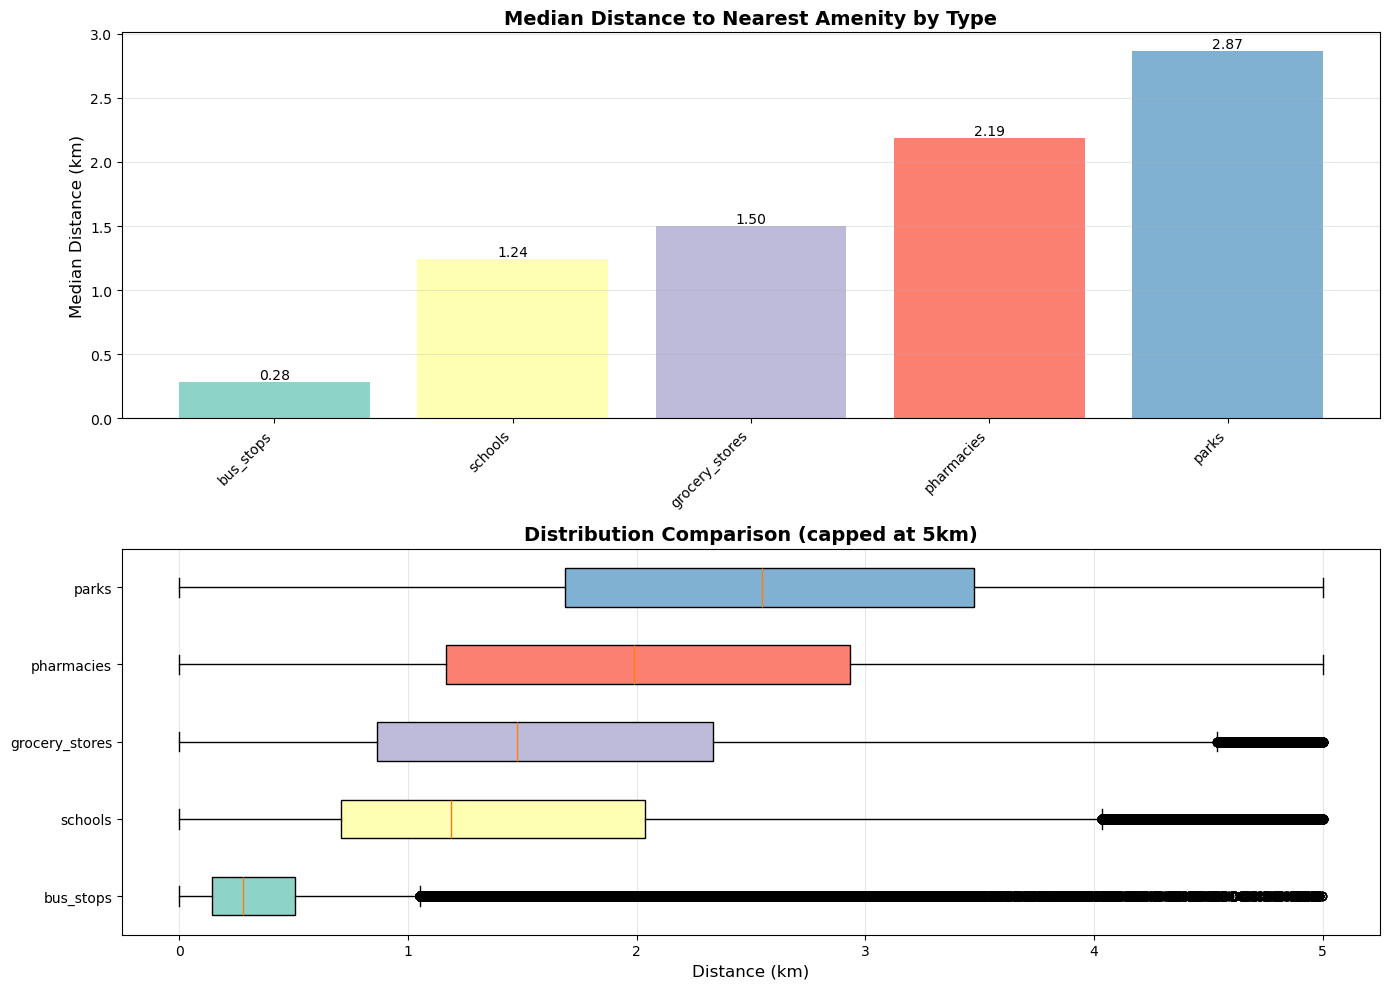

✓ Comparative visualization complete


In [14]:
print("Creating comparative visualizations...\n")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Bar chart of median distances
ax = axes[0]
colors = plt.cm.Set3(range(len(summary_df)))
bars = ax.bar(summary_df['amenity_type'], summary_df['median_dist_m']/1000, color=colors)
ax.set_ylabel('Median Distance (km)', fontsize=12)
ax.set_title('Median Distance to Nearest Amenity by Type', fontsize=14, fontweight='bold')
ax.set_xticklabels(summary_df['amenity_type'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=10)

# Box plot comparison
ax = axes[1]
box_data = []
labels = []
for amenity_key in summary_df['amenity_type']:
    if amenity_key in results and results[amenity_key] is not None:
        dist_col = f'dist_{amenity_key}_m'
        distances = results[amenity_key][dist_col].dropna() / 1000
        # Cap at 5km for better visualization
        distances = distances[distances <= 5]
        box_data.append(distances)
        labels.append(amenity_key)

bp = ax.boxplot(box_data, labels=labels, patch_artist=True, vert=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('Distance (km)', fontsize=12)
ax.set_title('Distribution Comparison (capped at 5km)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Comparative visualization complete")

## Test 12: Sample Output Export
Save results to demonstrate output format

In [15]:
print("Exporting sample results...\n")

# Create output directory
output_dir = Path("../data/test_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Export summary statistics
summary_path = output_dir / "amenity_distance_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"✓ Saved: {summary_path}")

# Export full results for bus stops (sample)
if 'bus_stops' in results and results['bus_stops'] is not None:
    bus_path = output_dir / "bus_stops_distances.geoparquet"
    results['bus_stops'].to_parquet(bus_path)
    print(f"✓ Saved: {bus_path}")
    
    # Also save a CSV sample (first 1000 rows, no geometry)
    sample_cols = ['full_address', 'city', 'zipcode', 'dist_bus_stops_m']
    csv_path = output_dir / "bus_stops_distances_sample.csv"
    results['bus_stops'][sample_cols].head(1000).to_csv(csv_path, index=False)
    print(f"✓ Saved: {csv_path} (1000 rows sample)")

print(f"\n✓ All outputs saved to: {output_dir}")

Exporting sample results...

✓ Saved: ../data/test_outputs/amenity_distance_summary.csv
✓ Saved: ../data/test_outputs/bus_stops_distances.geoparquet
✓ Saved: ../data/test_outputs/bus_stops_distances_sample.csv (1000 rows sample)

✓ All outputs saved to: ../data/test_outputs


## Test Summary

### Pipeline Tests Completed:

1. ✓ Load gold geometries
2. ✓ Load study area
3. ✓ Build walk network from OSM
4. ✓ Visualize network sample
5. ✓ Fetch amenities from OSM
6. ✓ Visualize amenities
7. ✓ Calculate distance to bus stops
8. ✓ Visualize distance distributions
9. ✓ Calculate distances for all amenities
10. ✓ Generate summary statistics
11. ✓ Create comparative visualizations
12. ✓ Export sample results

### Next Steps:

- Add travel time calculations (distance / walking speed)
- Aggregate results to census tract level
- Add more amenity types
- Integrate demographic data for equity analysis
- Expand to Contra Costa County
- Create final accessibility index

In [16]:
print("\n" + "="*80)
print("PIPELINE TEST COMPLETE")
print("="*80)
print("\nAll tests passed successfully!")
print("\nThe osmnx_pipeline is ready for full-scale analysis.")


PIPELINE TEST COMPLETE

All tests passed successfully!

The osmnx_pipeline is ready for full-scale analysis.
